In [1]:
# Importaciones básicas
import numpy as np
import pandas as pd
import datetime

# Visualización de datos
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocesamiento de datos
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder, OrdinalEncoder

# Modelos de machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, HuberRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

# Estadísticas y análisis
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

### IMPORTACIÓN DE LOS ARCHIVOS ###

In [2]:
cd /Users/thaisrocafull/Documents/CURSOS_I_APUNTS/data_science/PROYECTO_FINAL/SPOTIFY

/Users/thaisrocafull/Documents/CURSOS_I_APUNTS/data_science/PROYECTO_FINAL/SPOTIFY


In [3]:
df = pd.read_csv ('df.csv')

## PREPROCESADO ##

In [4]:
columnas_numericas = df.select_dtypes(include=['number'])
columnas_categóricas = df.select_dtypes(include=['object'])
print("Columnas Numéricas:")
print(columnas_numericas.columns)
print("\nColumnas Categóricas:")
print(columnas_categóricas.columns)

Columnas Numéricas:
Index(['Popularity Artist', 'Followers', 'Artist Song Rank',
       'Total Album Tracks', 'Song Duration', 'Popularity Song'],
      dtype='object')

Columnas Categóricas:
Index(['Gender', 'Country', 'Artist Name', 'Track Name', 'Album Name',
       'Main Genre'],
      dtype='object')


Antes de realizar la estandarización, realizamos un Boxplot para detectar los Outliers (valores atípicos) y de este modo eligir el modelo a aplicar.

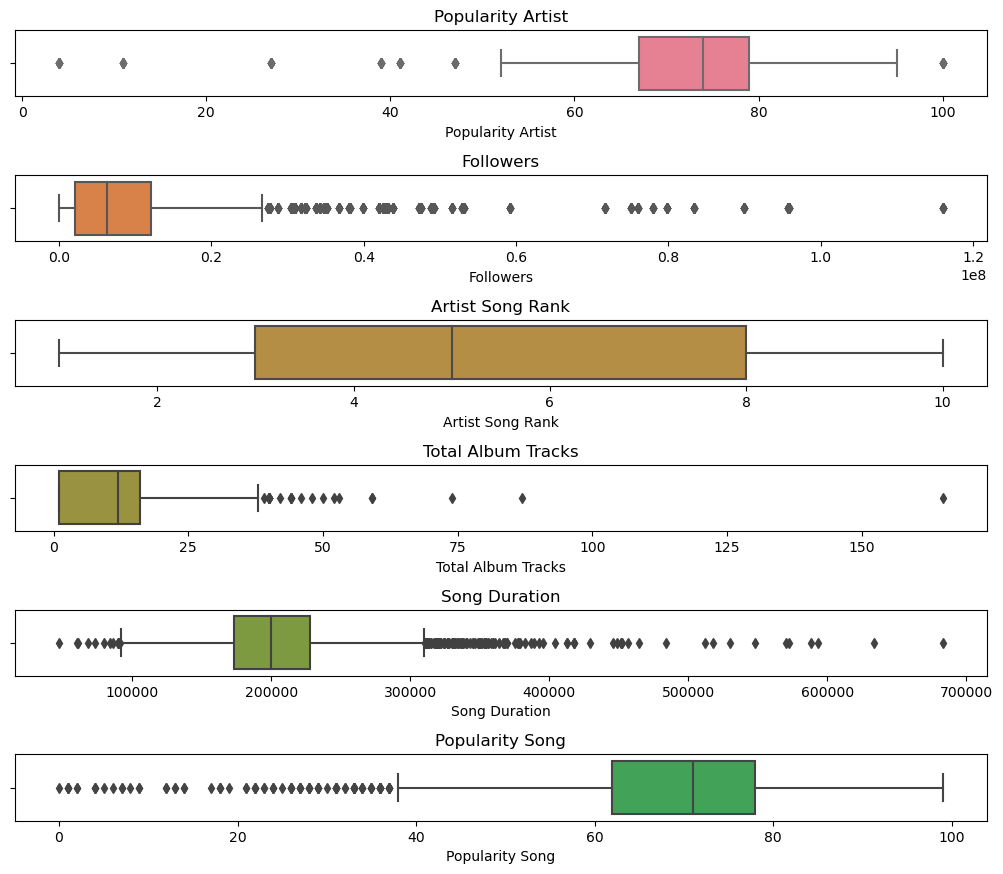

In [5]:
df_col_num = df.select_dtypes(include='number')

plt.figure(figsize=(20, 20))
palette = sns.color_palette("husl", n_colors=14)

for i, column in enumerate(df_col_num):
    plt.subplot(14, 2, 2*i + 1)
    sns.boxplot(x=df[column], orient="h",color=palette[i])
    plt.title(f'{column}')
    plt.tight_layout()

- Todas tienen outliers a excepcion de artist song rank, puesto que se tratará como categórica. (Es ordinal y no respondería a un valor numérico en los estúdios).

In [6]:
# Crear copia del DataFrame original
df_procesado = df.copy()
df_procesado = df_procesado.drop(['Track Name', 'Album Name'], axis=1, errors='ignore')
df_procesado.head()

,Gender,Country,Popularity Artist,Followers,Artist Name,Artist Song Rank,Total Album Tracks,Is Explicit,Song Duration,Popularity Song,Main Genre
0,male,CA,95,83298497,Drake,1,23,True,260111,93,Hip Hop
1,male,CA,95,83298497,Drake,2,23,True,247444,91,Hip Hop
2,male,CA,95,83298497,Drake,3,23,True,319191,89,Hip Hop
3,male,CA,95,83298497,Drake,4,14,True,218364,89,Hip Hop
4,male,CA,95,83298497,Drake,5,20,False,173986,89,Hip Hop


- Procesamos primero 'Artist Song Rank' para que cuente como ordinal y pueda ser tratado como una categoría.

In [7]:
encoder = OrdinalEncoder()
df_procesado['Artist Song Rank'] = pd.to_numeric(df_procesado['Artist Song Rank'], errors='coerce')

# Reshape la columna 'Artist Song Rank' para que sea una matriz 2D (n_samples, n_features)
rank_column_reshaped = df_procesado['Artist Song Rank'].values.reshape(-1, 1)

# Aplica el encoder
df_procesado['Artist Song Rank'] = encoder.fit_transform(rank_column_reshaped)

- Convertimos 'Is Explicit' de booleano a int para que pueda ser tratada numericamente (0/1) y no como (True / False)

In [8]:
df_procesado['Is Explicit'] = pd.to_numeric(df_procesado['Is Explicit'], errors='coerce')

In [9]:
# Selecciono columnas categóricas
columnas_categoricas = df_procesado[['Gender', 'Country', 'Main Genre', 'Artist Name','Is Explicit']]
df_procesado = pd.concat([df_procesado.drop(columnas_categoricas, axis=1), pd.get_dummies(columnas_categoricas, drop_first=True)], axis=1)

# 'Popularity Song' no se aplica transformación puesto que es el target.

# Variables numéricas con outliers (aplicar RobustScaler)
columnas_con_outliers = df_procesado[['Popularity Artist', 'Followers', 'Total Album Tracks', 'Song Duration']]

# Aplicar RobustScaler a las columnas con outliers
scaler_robust = RobustScaler()
df_procesado[columnas_con_outliers.columns] = scaler_robust.fit_transform(df_procesado[columnas_con_outliers.columns])

In [10]:
df_procesado.head().round(0)

,Popularity Artist,Followers,Artist Song Rank,Total Album Tracks,Song Duration,Popularity Song,Is Explicit,Gender_male,Gender_mixed,Gender_other,...,Artist Name_Zara Larsson,Artist Name_Zion & Lennox,Artist Name_Zion.T,Artist Name_Zé Neto & Cristiano,Artist Name_bbno$,Artist Name_beabadoobee,Artist Name_benny blanco,Artist Name_blackbear,Artist Name_gnash,Artist Name_Ñengo Flow
0,2.0,8.0,0.0,1.0,1.0,93,True,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2.0,8.0,1.0,1.0,1.0,91,True,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2.0,8.0,2.0,1.0,2.0,89,True,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2.0,8.0,3.0,0.0,0.0,89,True,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2.0,8.0,4.0,1.0,-0.0,89,False,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
df_procesado.describe().round(0)

,Popularity Artist,Followers,Artist Song Rank,Total Album Tracks,Song Duration,Popularity Song,Gender_male,Gender_mixed,Gender_other,Country_AT,...,Artist Name_Zara Larsson,Artist Name_Zion & Lennox,Artist Name_Zion.T,Artist Name_Zé Neto & Cristiano,Artist Name_bbno$,Artist Name_beabadoobee,Artist Name_benny blanco,Artist Name_blackbear,Artist Name_gnash,Artist Name_Ñengo Flow
count,4037.0,4037.0,4037.0,4037.0,4037.0,4037.0,4037.0,4037.0,4037.0,4037.0,...,4037.0,4037.0,4037.0,4037.0,4037.0,4037.0,4037.0,4037.0,4037.0,4037.0
mean,-0.0,1.0,4.0,-0.0,0.0,69.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,1.0,2.0,3.0,1.0,1.0,13.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,-6.0,-1.0,0.0,-1.0,-3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,-1.0,-0.0,2.0,-1.0,-0.0,62.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,4.0,0.0,0.0,71.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,1.0,7.0,0.0,1.0,78.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,2.0,11.0,9.0,10.0,9.0,99.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


## ENTRENAMIENTO ##

In [12]:
X = df_procesado.drop('Popularity Song', axis=1) #data
y = df_procesado['Popularity Song'] #target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [13]:
X_train.describe().round(0)

,Popularity Artist,Followers,Artist Song Rank,Total Album Tracks,Song Duration,Gender_male,Gender_mixed,Gender_other,Country_AT,Country_AU,...,Artist Name_Zara Larsson,Artist Name_Zion & Lennox,Artist Name_Zion.T,Artist Name_Zé Neto & Cristiano,Artist Name_bbno$,Artist Name_beabadoobee,Artist Name_benny blanco,Artist Name_blackbear,Artist Name_gnash,Artist Name_Ñengo Flow
count,3229.0,3229.0,3229.0,3229.0,3229.0,3229.0,3229.0,3229.0,3229.0,3229.0,...,3229.0,3229.0,3229.0,3229.0,3229.0,3229.0,3229.0,3229.0,3229.0,3229.0
mean,-0.0,1.0,5.0,-0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,1.0,2.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,-6.0,-1.0,0.0,-1.0,-3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,-1.0,-0.0,2.0,-1.0,-0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,-0.0,5.0,0.0,-0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,1.0,7.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,2.0,11.0,9.0,5.0,9.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [14]:
X_test.describe().round(0)

,Popularity Artist,Followers,Artist Song Rank,Total Album Tracks,Song Duration,Gender_male,Gender_mixed,Gender_other,Country_AT,Country_AU,...,Artist Name_Zara Larsson,Artist Name_Zion & Lennox,Artist Name_Zion.T,Artist Name_Zé Neto & Cristiano,Artist Name_bbno$,Artist Name_beabadoobee,Artist Name_benny blanco,Artist Name_blackbear,Artist Name_gnash,Artist Name_Ñengo Flow
count,808.0,808.0,808.0,808.0,808.0,808.0,808.0,808.0,808.0,808.0,...,808.0,808.0,808.0,808.0,808.0,808.0,808.0,808.0,808.0,808.0
mean,-0.0,1.0,4.0,-0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,1.0,2.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,-6.0,-1.0,0.0,-1.0,-2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,-1.0,-0.0,2.0,-1.0,-0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,1.0,7.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,2.0,11.0,9.0,10.0,6.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Vamos a ver si hay multicolonialidad (correlación alta entre variables) con el test de VIF. 

In [15]:
# Selecciona solo las variables predictoras de interés
X_selected = df_procesado[['Popularity Artist', 'Followers', 'Song Duration', 'Popularity Song','Total Album Tracks']]

# Agrega una constante
X_selected_with_constant = sm.add_constant(X_selected)

# Calcula el VIF para cada variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_selected_with_constant.columns
vif_data["VIF"] = [variance_inflation_factor(X_selected_with_constant.values, i) for i in range(X_selected_with_constant.shape[1])]

print(vif_data)

             Variable        VIF
0               const  79.102739
1   Popularity Artist   3.395123
2           Followers   1.561414
3       Song Duration   1.028747
4     Popularity Song   2.689992
5  Total Album Tracks   1.075097


Los valores VIF obtenidos son relativamente bajos (menos de 5) y sugieren que estas variables tiene baja multicolinealidad con las demás variables en el modelo. Lo que implicará que no deberíamos tener problemas con los entrenamientos en este ámbito.

In [20]:
# Define tus datos de entrenamiento y prueba (X_train, X_test, y_train, y_test)

models = {
    'Ridge Regression': Ridge(),
    'Random Forest': RandomForestRegressor(),
    'Support Vector Machine (RBF Kernel)': SVR(kernel='rbf'),
    'Huber Regression': HuberRegressor(max_iter=1000),
    'Decision Tree': DecisionTreeRegressor(),
    'Gradient Boosted Trees': GradientBoostingRegressor()
}

# Evaluar cada modelo y calcular métricas
metrics_dict = {'mse': [], 'r2': []}
model_names = []

for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    # Calcular métricas
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    # Almacenar métricas
    metrics_dict['mse'].append(mse)
    metrics_dict['r2'].append(r2)
    model_names.append(name)

# Mostrar las métricas
for name, metrics in zip(model_names, zip(metrics_dict['mse'], metrics_dict['r2'])):
    print(f"{name} Metrics:")
    print(f"Mean Squared Error (MSE): {metrics[0]}")
    print(f"R-squared (R2): {metrics[1]}")
    print("\n")

Ridge Regression Metrics:
Mean Squared Error (MSE): 30.286014932665843
R-squared (R2): 0.8238392622457211


Random Forest Metrics:
Mean Squared Error (MSE): 27.808511138613863
R-squared (R2): 0.8382498374607023


Support Vector Machine (RBF Kernel) Metrics:
Mean Squared Error (MSE): 45.345549588288755
R-squared (R2): 0.7362444188479091


Huber Regression Metrics:
Mean Squared Error (MSE): 31.814099530804423
R-squared (R2): 0.8149510506154514


Decision Tree Metrics:
Mean Squared Error (MSE): 50.804455445544555
R-squared (R2): 0.7044923086649306


Gradient Boosted Trees Metrics:
Mean Squared Error (MSE): 29.43448628900406
R-squared (R2): 0.8287922385425321




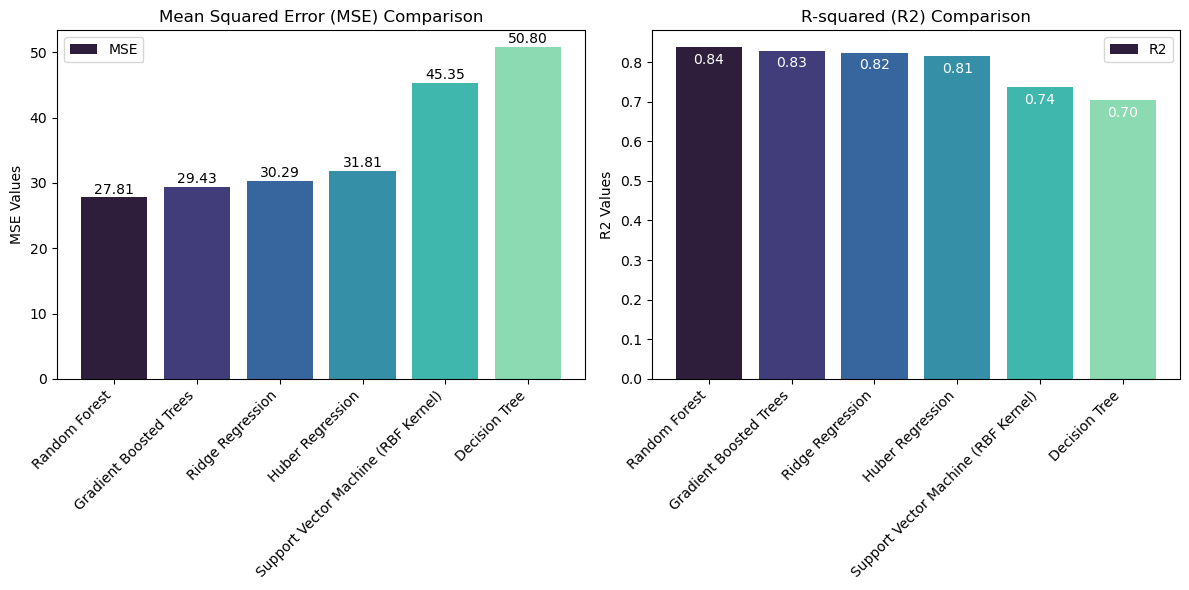

In [21]:
# Ordenar modelos según el MSE
sorted_indices_mse = sorted(range(len(metrics_dict['mse'])), key=lambda k: metrics_dict['mse'][k])
sorted_model_names_mse = [model_names[i] for i in sorted_indices_mse]
sorted_mse_values = [metrics_dict['mse'][i] for i in sorted_indices_mse]
sorted_r2_values = [metrics_dict['r2'][i] for i in sorted_indices_mse]

# Configuración común para ambos gráficos
def configure_axes(ax, title, ylabel):
    ax.set_xticks(np.arange(len(model_names)))
    ax.set_xticklabels(sorted_model_names_mse, rotation=45, ha='right')
    ax.legend()
    ax.set_title(title)
    ax.set_ylabel(ylabel)

# Crear subgráficos con 1 fila y 2 columnas
fig, (ax_mse, ax_r2) = plt.subplots(1, 2, figsize=(12, 6))

# Gráfico de barras para MSE con paleta viridis
mse_bars = ax_mse.bar(np.arange(len(model_names)), sorted_mse_values, label='MSE', color=sns.color_palette("mako"))

# Anotaciones en las barras de MSE
for i, mse in enumerate(sorted_mse_values):
    ax_mse.text(i, mse + 0.1, f'{mse:.2f}', ha='center', va='bottom')

# Configuraciones del gráfico de MSE
configure_axes(ax_mse, 'Mean Squared Error (MSE) Comparison', 'MSE Values')

# Gráfico de barras para R2 con paleta mako
r2_bars = ax_r2.bar(np.arange(len(model_names)), sorted_r2_values, label='R2', color=sns.color_palette("mako"))

# Anotaciones dentro de las barras de R2
for i, r2 in enumerate(sorted_r2_values):
    ax_r2.text(i, r2 - 0.05, f'{r2:.2f}', ha='center', va='bottom', color='white', fontsize=10)

# Configuraciones del gráfico de R2
configure_axes(ax_r2, 'R-squared (R2) Comparison', 'R2 Values')

# Ajuste de diseño para el título de la segunda gráfica
fig.subplots_adjust(top=0.85)

plt.tight_layout()
plt.show()

- Observamos que los resultados del Mean Squared son bastante parecidos en los cuatro primeros modelos y se disparan en SVM y Decision Tree. 
- Los R2 también son muy buenos en los cuatro primeros modelos.

Aplico algunos hiperparámetros a los 3 modelos con los mejores resultados (Random Fores, Gradien Boosted Trees y Ridge Regression) y aplico el Grid Search para que me busque los mejores.

In [22]:
models_parameters = {
    'Ridge Regression': {'alpha': [0.1, 1.0, 10.0], 'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]},
    'Gradient Boosted Trees': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 4, 5]}
}
results_list = []

# Búsqueda de los mejores hiperparámetros para cada modelo con GridSearchCV
best_models = {}
scorers = {
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'R^2': make_scorer(r2_score)
}

for model_name, model_params in models_parameters.items():
    model = models[model_name]
    param_grid = model_params
    
    best_models[model_name] = {}

    for metric_name, scorer in scorers.items():
        grid_search = GridSearchCV(model, param_grid, scoring=scorer, cv=5, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        
        best_models[model_name][metric_name] = {
            'best_model': grid_search.best_estimator_,
            'best_params': grid_search.best_params_,
            'best_score': grid_search.best_score_
        }
 # Agrego los resultados a la lista
        results_list.append({
            'Model': model_name,
            'Metric': metric_name,
            'Best Parameters': grid_search.best_params_,
            'Best Score': grid_search.best_score_
        })

        print(f"\nMejores parámetros para {model_name} - {metric_name}: {grid_search.best_params_}")
        print(f"Mejor puntuación para {model_name} - {metric_name}: {grid_search.best_score_:.4f}")

results_df = pd.DataFrame(results_list)
results_df


Mejores parámetros para Ridge Regression - MSE: {'alpha': 1.0, 'solver': 'saga'}
Mejor puntuación para Ridge Regression - MSE: -34.9513

Mejores parámetros para Ridge Regression - R^2: {'alpha': 1.0, 'solver': 'saga'}
Mejor puntuación para Ridge Regression - R^2: 0.7951

Mejores parámetros para Random Forest - MSE: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Mejor puntuación para Random Forest - MSE: -36.0488

Mejores parámetros para Random Forest - R^2: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Mejor puntuación para Random Forest - R^2: 0.7886

Mejores parámetros para Gradient Boosted Trees - MSE: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 200}
Mejor puntuación para Gradient Boosted Trees - MSE: -35.5695

Mejores parámetros para Gradient Boosted Trees - R^2: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 200}
Mejor puntuación para Gradient Boosted Trees - R^2: 0.7902


,Model,Metric,Best Parameters,Best Score
0,Ridge Regression,MSE,"{'alpha': 1.0, 'solver': 'saga'}",-34.951296
1,Ridge Regression,R^2,"{'alpha': 1.0, 'solver': 'saga'}",0.795110
2,Random Forest,MSE,"{'max_depth': None, 'min_samples_split': 5, 'n...",-36.048786
3,Random Forest,R^2,"{'max_depth': 20, 'min_samples_split': 2, 'n_e...",0.788591
4,Gradient Boosted Trees,MSE,"{'learning_rate': 0.2, 'max_depth': 4, 'n_esti...",-35.569512
5,Gradient Boosted Trees,R^2,"{'learning_rate': 0.2, 'max_depth': 4, 'n_esti...",0.790237


- Aqui observamos los mejores hiperparámetros y la puntuación, que ha salido bastante buena también y parecida en los tres modelos

Entrenamos los modelos con los mejores hiperparámetros y observamos si han mejorado.

In [23]:
# Entrenar los modelos con los mejores hiperparámetros para MSE
for model_name, params_dict in best_models.items():
    model = params_dict['MSE']['best_model']
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    # Calcular métricas
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    print(f'Modelo {model_name} con mejores hiperparámetros MSE - MSE: {mse:.4f}, R^2: {r2:.4f}')

Modelo Ridge Regression con mejores hiperparámetros MSE - MSE: 30.2767, R^2: 0.8239
Modelo Random Forest con mejores hiperparámetros MSE - MSE: 26.9622, R^2: 0.8432
Modelo Gradient Boosted Trees con mejores hiperparámetros MSE - MSE: 27.4993, R^2: 0.8400


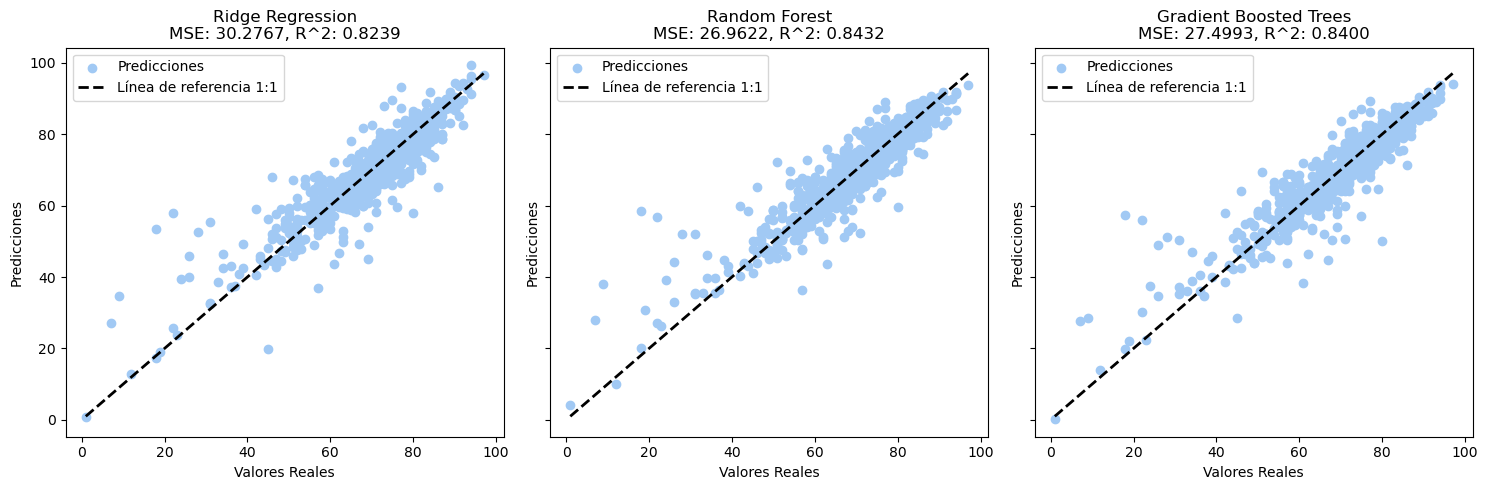

In [27]:
# Modelos y predicciones
model_names = ['Ridge Regression', 'Random Forest', 'Gradient Boosted Trees']
models = [best_models[name]['MSE']['best_model'] for name in model_names]

# Crear subgráficos
fig, axs = plt.subplots(1, len(models), figsize=(15, 5), sharey=True)

# Iterar sobre modelos y graficar
for i, (model, model_name) in enumerate(zip(models, model_names)):
    predictions = model.predict(X_test)
    
    # Gráfico de dispersión de predicciones vs. valores reales
    axs[i].scatter(y_test, predictions, label='Predicciones')
    axs[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--k', lw=2, label='Línea de referencia 1:1')
    axs[i].set_xlabel('Valores Reales')
    axs[i].set_ylabel('Predicciones')
    axs[i].set_title(f'{model_name}\nMSE: {mean_squared_error(y_test, predictions):.4f}, R^2: {r2_score(y_test, predictions):.4f}')
    axs[i].legend()

plt.tight_layout()
plt.show()


**Visualización del rendimiento de los modelos**

-  **Random Forest**, es el modelo que ha dado el mejor resultado, precedido por **Gradient Boosted Trees**, destacando con ligera diferencia de las demás en general. 

- **Ridge** también obtubo un buen resultado pero el modelo con el que nos quedamos es RANDOM FOREST.

**Visualización de Residuales de los modelos**

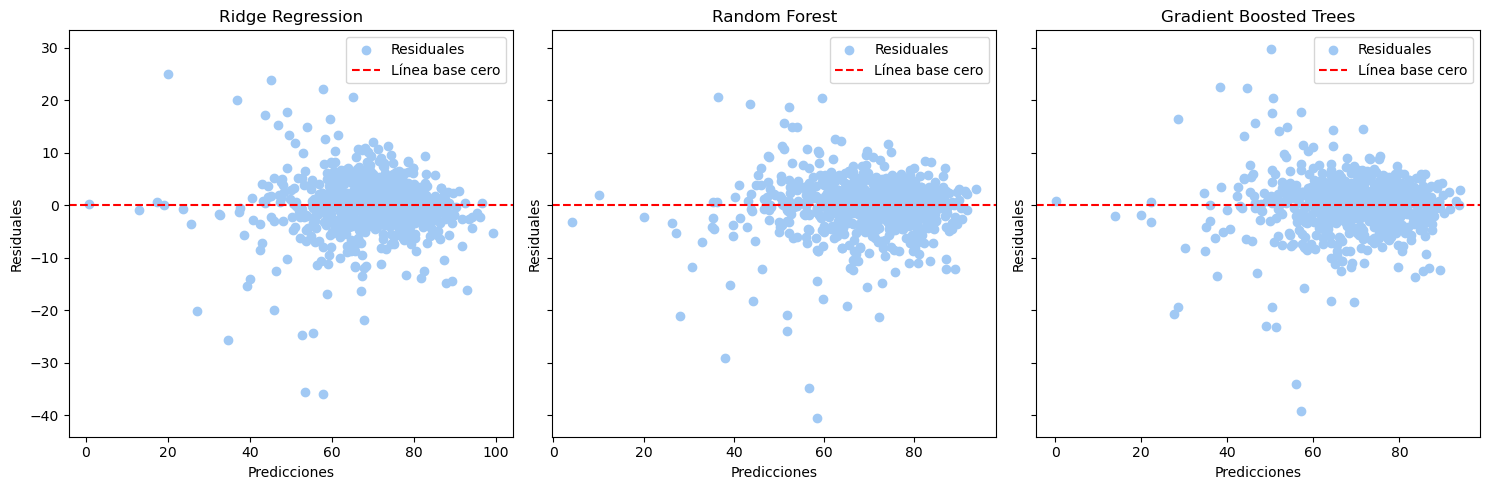

In [30]:
# Crear subgráficos para los residuales
fig_residuales, axs_residuales = plt.subplots(1, len(models), figsize=(15, 5), sharey=True)

# Iterar sobre modelos y graficar los residuales
for i, (model, model_name) in enumerate(zip(models, model_names)):
    predictions = model.predict(X_test)
    residuales = y_test - predictions
    
    # Gráfico de dispersión de residuales vs. valores predichos
    axs_residuales[i].scatter(predictions, residuales, label='Residuales')
    axs_residuales[i].axhline(y=0, color='r', linestyle='--', label='Línea base cero')
    axs_residuales[i].set_xlabel('Predicciones')
    axs_residuales[i].set_ylabel('Residuales')
    axs_residuales[i].set_title(f'{model_name}')
    axs_residuales[i].legend()

plt.tight_layout()
plt.show()


- Los residuales son la diferencia entre los valores observados y los valores predichos en un modelo.
cuanto mas cercano esten los puntos a la diagonal (x=y) mas preciso es el modelo. Los puntos en Gradient estan sutílmente más dispersos que en los otros. Aunque todos tienen puntos disperos. Lo que tambien supone variabilidad de datos.

- Hago una tabla para visualizar a nivel numérico las predicciones frente a los valores reales

In [48]:
results_before = {
    'Modelo': ['Ridge Regression', 'Random Forest', 'Support Vector Machine (RBF Kernel)',
               'Huber Regression', 'Decision Tree', 'Gradient Boosted Trees'],
    'MSE_Antes': [30.286014932665843, 27.808511138613863, 45.345549588288755,
                  31.814099530804423, 50.804455445544555, 29.43448628900406],
    'R2_Antes': [0.8238392622457211, 0.8382498374607023, 0.7362444188479091,
                 0.8149510506154514, 0.7044923086649306, 0.8287922385425321]
}

results_after = {
    'Modelo': ['Ridge Regression', 'Random Forest', 'Gradient Boosted Trees'],
    'MSE_Despues': [30.2767, 26.9622, 27.4993],
    'R2_Despues': [0.8239, 0.8432, 0.8400]
}

df_before = pd.DataFrame(results_before)
df_after = pd.DataFrame(results_after)

df_combinado = pd.merge(df_before, df_after, on='Modelo')
df_combinado

,Modelo,MSE_Antes,R2_Antes,MSE_Despues,R2_Despues
0,Ridge Regression,30.286015,0.823839,30.2767,0.8239
1,Random Forest,27.808511,0.838250,26.9622,0.8432
2,Gradient Boosted Trees,29.434486,0.828792,27.4993,0.8400


- La mejora de hiperparámetros tuvo un impacto positivo en el rendimiento de Gradient Boosted Trees y Random Forest, reduciendo el MSE y mejorando el R2.
- Los resultados de Ridge Regression se mantuvieron sólidos.

In [51]:
selected_model_name = 'Random Forest'
selected_params_dict = best_models[selected_model_name]['MSE']
selected_model = selected_params_dict['best_model']

# Entrenar el modelo seleccionado
selected_model.fit(X_train, y_train)
predictions = selected_model.predict(X_test)

# Calcular métricas
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Imprimir métricas
print(f'Modelo {selected_model_name} con mejores hiperparámetros MSE - MSE: {mse:.4f}, R^2: {r2:.4f}')

# Guardar el modelo seleccionado
dump(selected_model, 'selected_model.joblib')

Modelo Random Forest con mejores hiperparámetros MSE - MSE: 26.5240, R^2: 0.8457


['selected_model.joblib']

## Conclusión: ## 
### Nos quedamos con RANDOM FOREST como modelo por haber sido el más estable y con mejor puntuación, aunque los tres modelos han ofrecido un muy buen rendimiento y serían óptimos para obtener mi objetivo: "Construir y evaluar modelos de aprendizaje automático para aplicaciones específicas en la industria de la música y el entretenimiento." ###